# LSTM Poker Agent with PokerKit

This notebook implements a Deep Recurrent Q-Network (DRQN) agent for No-Limit Texas Hold'em using **PokerKit** as the game engine.

## Key Features:
- **Dual-Input Architecture**: MLP for game state + LSTM for opponent action history
- **Session-Based Memory**: LSTM hidden state persists across hands within a session
- **Opponent Modeling**: Agent adapts to different opponent playing styles

In [1]:
# Cell 1: Dependencies & Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import random
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict, Any

from pokerkit import Automation, NoLimitTexasHoldem, Card

# Constants
MAX_HISTORY_LEN = 20
SEED = 42

# Set random seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Action Encoding

# Action tokens for history encoding
ACTION_FOLD = 0
ACTION_CHECK_CALL = 1
ACTION_BET_RAISE = 2
ACTION_PAD = 3  # For padding shorter sequences
NUM_ACTION_TOKENS = 4

# Environment action space
ENV_FOLD = 0
ENV_CHECK_CALL = 1
ENV_BET_RAISE = 2
NUM_ACTIONS = 3

In [3]:
# Cell 3: Custom Gym Wrapper for PokerKit

class PokerKitGymEnv(gym.Env):
    """
    Gymnasium wrapper for PokerKit's No-Limit Texas Hold'em.
    
    Observation Space (Dict):
        - game_state: Normalized vector of cards and chips
        - action_history: Sequence of opponent action tokens
    
    Action Space: Discrete(3) - Fold, Check/Call, Bet/Raise
    """
    
    def __init__(self, num_players: int = 2, starting_stack: int = 1000, 
                 small_blind: int = 5, big_blind: int = 10):
        super().__init__()
        
        self.num_players = num_players
        self.starting_stack = starting_stack
        self.small_blind = small_blind
        self.big_blind = big_blind
        
        # Game state dimensions:
        # - Hole cards: 2 cards * 52 one-hot = 104
        # - Board cards: 5 cards * 52 one-hot = 260  
        # - Stack sizes: num_players normalized values
        # - Pot size: 1 normalized value
        # - Current player position: 1 value
        # - Street indicator: 4 values (preflop, flop, turn, river)
        self.game_state_dim = 104 + 260 + num_players + 1 + 1 + 4
        
        self.observation_space = spaces.Dict({
            'game_state': spaces.Box(low=0, high=1, shape=(self.game_state_dim,), dtype=np.float32),
            'action_history': spaces.Box(low=0, high=NUM_ACTION_TOKENS-1, 
                                         shape=(MAX_HISTORY_LEN,), dtype=np.int64)
        })
        
        self.action_space = spaces.Discrete(NUM_ACTIONS)
        
        self.state = None
        self.action_history = deque(maxlen=MAX_HISTORY_LEN)
        self.agent_player_index = 0  # Our agent is always player 0
        
    def _card_to_index(self, card: Card) -> int:
        """Convert a PokerKit Card to a 0-51 index."""
        ranks = '23456789TJQKA'
        suits = 'cdhs'
        rank_idx = ranks.index(card.rank)
        suit_idx = suits.index(card.suit)
        return rank_idx * 4 + suit_idx
    
    def _encode_card(self, card: Optional[Card]) -> np.ndarray:
        """One-hot encode a single card (52 dimensions)."""
        encoding = np.zeros(52, dtype=np.float32)
        if card is not None:
            encoding[self._card_to_index(card)] = 1.0
        return encoding
    
    def _flatten_cards(self, cards) -> List:
        """Flatten nested card tuples from PokerKit."""
        flat = []
        for item in cards:
            if hasattr(item, 'rank'):  # It's a Card object
                flat.append(item)
            else:  # It's a tuple/list of cards
                flat.extend(self._flatten_cards(item))
        return flat
    
    def _get_game_state(self) -> np.ndarray:
        """Extract and encode current game state."""
        state_vector = []
        
        # Encode hole cards (agent's cards only) - flatten nested structure
        hole_cards = self._flatten_cards(self.state.hole_cards[self.agent_player_index])
        for i in range(2):
            if i < len(hole_cards):
                state_vector.extend(self._encode_card(hole_cards[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        # Encode board cards - flatten nested structure
        board_cards = self._flatten_cards(self.state.board_cards)
        for i in range(5):
            if i < len(board_cards):
                state_vector.extend(self._encode_card(board_cards[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        # Encode stack sizes (normalized by starting stack)
        for i in range(self.num_players):
            stack = self.state.stacks[i] / self.starting_stack
            state_vector.append(min(stack, 2.0))  # Cap at 2x starting
        
        # Pot size (normalized)
        total_pot = sum(self.state.bets)
        state_vector.append(total_pot / (self.starting_stack * self.num_players))
        
        # Current player position (normalized)
        if self.state.actor_index is not None:
            state_vector.append(self.state.actor_index / (self.num_players - 1))
        else:
            state_vector.append(0.0)
        
        # Street indicator (one-hot: preflop, flop, turn, river)
        street = [0.0, 0.0, 0.0, 0.0]
        num_board = len(board_cards)
        if num_board == 0:
            street[0] = 1.0  # Preflop
        elif num_board == 3:
            street[1] = 1.0  # Flop
        elif num_board == 4:
            street[2] = 1.0  # Turn
        else:
            street[3] = 1.0  # River
        state_vector.extend(street)
        
        return np.array(state_vector, dtype=np.float32)
    
    def _get_action_history(self) -> np.ndarray:
        """Get padded action history array."""
        history = list(self.action_history)
        # Pad to MAX_HISTORY_LEN
        while len(history) < MAX_HISTORY_LEN:
            history.insert(0, ACTION_PAD)
        return np.array(history[-MAX_HISTORY_LEN:], dtype=np.int64)
    
    def _get_observation(self) -> Dict[str, np.ndarray]:
        """Construct the full observation dict."""
        return {
            'game_state': self._get_game_state(),
            'action_history': self._get_action_history()
        }
    
    def _get_legal_actions(self) -> List[int]:
        """Get list of legal actions for current player."""
        legal = []
        if self.state.can_fold():
            legal.append(ENV_FOLD)
        if self.state.can_check_or_call():
            legal.append(ENV_CHECK_CALL)
        if self.state.can_complete_bet_or_raise_to():
            legal.append(ENV_BET_RAISE)
        return legal if legal else [ENV_CHECK_CALL]
    
    def _execute_action(self, action: int) -> None:
        """Execute an action in the PokerKit state."""
        if action == ENV_FOLD:
            if self.state.can_fold():
                self.state.fold()
            elif self.state.can_check_or_call():
                self.state.check_or_call()
        elif action == ENV_CHECK_CALL:
            if self.state.can_check_or_call():
                self.state.check_or_call()
            elif self.state.can_fold():
                self.state.fold()
        elif action == ENV_BET_RAISE:
            if self.state.can_complete_bet_or_raise_to():
                # Raise to 2x current bet or pot-sized
                min_raise = self.state.min_completion_betting_or_raising_to_amount
                max_raise = self.state.max_completion_betting_or_raising_to_amount
                raise_amount = min(min_raise * 2, max_raise)
                self.state.complete_bet_or_raise_to(raise_amount)
            elif self.state.can_check_or_call():
                self.state.check_or_call()
    
    def _run_automations(self) -> None:
        """Run automated game actions (dealing, collecting bets, etc)."""
        while self.state.can_burn_card():
            self.state.burn_card('??')
        while self.state.can_deal_board():
            self.state.deal_board()
        while self.state.can_push_chips():
            self.state.push_chips()
        while self.state.can_pull_chips():
            self.state.pull_chips()
    
    def _action_to_token(self, action: int) -> int:
        """Convert environment action to history token."""
        if action == ENV_FOLD:
            return ACTION_FOLD
        elif action == ENV_CHECK_CALL:
            return ACTION_CHECK_CALL
        else:
            return ACTION_BET_RAISE
    
    def reset(self, seed=None, options=None) -> Tuple[Dict[str, np.ndarray], Dict]:
        """Reset the environment for a new hand."""
        super().reset(seed=seed)
        
        # Create new game state
        self.state = NoLimitTexasHoldem.create_state(
            automations=(
                Automation.ANTE_POSTING,
                Automation.BET_COLLECTION,
                Automation.BLIND_OR_STRADDLE_POSTING,
                Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
                Automation.HAND_KILLING,
                Automation.CHIPS_PUSHING,
                Automation.CHIPS_PULLING,
            ),
            ante_trimming_status=True,
            raw_antes={-1: 0},
            raw_blinds_or_straddles=(self.small_blind, self.big_blind),
            min_bet=self.big_blind,
            raw_starting_stacks=[self.starting_stack] * self.num_players,
            player_count=self.num_players,
        )
        
        # Deal hole cards
        while self.state.can_deal_hole():
            self.state.deal_hole()
        
        self._run_automations()
        
        return self._get_observation(), {'legal_actions': self._get_legal_actions()}
    
    def reset_session(self) -> None:
        """Reset for new session (clears action history)."""
        self.action_history.clear()
    
    def step(self, action: int) -> Tuple[Dict[str, np.ndarray], float, bool, bool, Dict]:
        """Execute one step in the environment."""
        current_player = self.state.actor_index
        
        # Record action in history (for opponent modeling)
        if current_player != self.agent_player_index:
            self.action_history.append(self._action_to_token(action))
        
        # Execute the action
        self._execute_action(action)
        self._run_automations()
        
        # Check if hand is over
        done = self.state.status is False  # Game is complete
        
        # Calculate reward (only at end of hand for agent)
        reward = 0.0
        if done:
            # Reward is change in stack from starting
            final_stack = self.state.stacks[self.agent_player_index]
            reward = (final_stack - self.starting_stack) / self.big_blind
        
        obs = self._get_observation()
        info = {
            'legal_actions': self._get_legal_actions() if not done else [],
            'current_player': self.state.actor_index if not done else None
        }
        
        return obs, reward, done, False, info
    
    def get_current_player(self) -> Optional[int]:
        """Return current player index or None if hand is over."""
        if self.state.status is False:
            return None
        return self.state.actor_index

In [4]:
# Cell 4: Sequence Replay Buffer (Session-Aware)

class SequenceReplayBuffer:
    """
    Replay buffer that stores full episodes (hands) with session information.
    
    Each episode includes the LSTM hidden state at the start of the hand,
    allowing us to properly train the recurrent network.
    """
    
    def __init__(self, capacity: int = 5000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, episode: List[Tuple], initial_hidden: Tuple[torch.Tensor, torch.Tensor]):
        """
        Store an episode with its initial hidden state.
        
        Episode format: [(obs, action, reward, next_obs, done, legal_actions), ...]
        """
        self.buffer.append((episode, initial_hidden))
    
    def sample(self, batch_size: int):
        """Sample a batch of episodes for training."""
        batch = random.sample(list(self.buffer), min(batch_size, len(self.buffer)))
        return batch
    
    def __len__(self):
        return len(self.buffer)

In [5]:
# Cell 5: Dual-Input Agent Model

class DualInputAgent(nn.Module):
    """
    DRQN Agent with dual-input architecture:
    1. MLP branch processes current game state (cards, chips)
    2. LSTM branch processes opponent action history
    
    The LSTM hidden state is maintained across hands within a session,
    allowing the agent to model opponent patterns.
    """
    
    def __init__(self, game_state_dim: int, action_vocab_size: int = NUM_ACTION_TOKENS,
                 hidden_dim: int = 128, embed_dim: int = 32, num_actions: int = NUM_ACTIONS):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        # MLP Branch for game state
        self.mlp = nn.Sequential(
            nn.Linear(game_state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, hidden_dim),
            nn.ReLU()
        )
        
        # LSTM Branch for action history
        self.action_embedding = nn.Embedding(action_vocab_size, embed_dim, padding_idx=ACTION_PAD)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, 
                           num_layers=1, batch_first=True)
        
        # Output head (combines both branches)
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
    
    def forward(self, game_state: torch.Tensor, history_seq: torch.Tensor, 
                hidden: Optional[Tuple[torch.Tensor, torch.Tensor]] = None) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        Forward pass.
        
        Args:
            game_state: (batch, game_state_dim) current game features
            history_seq: (batch, seq_len) opponent action history
            hidden: Optional LSTM hidden state (h, c)
        
        Returns:
            q_values: (batch, num_actions) Q-values for each action
            new_hidden: Updated LSTM hidden state
        """
        batch_size = game_state.size(0)
        
        # MLP branch
        mlp_out = self.mlp(game_state)  # (batch, hidden_dim)
        
        # LSTM branch
        action_embeds = self.action_embedding(history_seq)  # (batch, seq_len, embed_dim)
        
        if hidden is None:
            hidden = self.init_hidden(batch_size, game_state.device)
        
        lstm_out, new_hidden = self.lstm(action_embeds, hidden)
        lstm_out = lstm_out[:, -1, :]  # Take last output: (batch, hidden_dim)
        
        # Combine branches
        combined = torch.cat([mlp_out, lstm_out], dim=1)  # (batch, hidden_dim * 2)
        
        # Output Q-values
        q_values = self.output_head(combined)  # (batch, num_actions)
        
        return q_values, new_hidden
    
    def init_hidden(self, batch_size: int, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        """Initialize LSTM hidden state."""
        h = torch.zeros(1, batch_size, self.hidden_dim, device=device)
        c = torch.zeros(1, batch_size, self.hidden_dim, device=device)
        return (h, c)

In [6]:
# Cell 6: Fixed-Strategy Opponents

class ManiacAgent:
    """Always raises/bets when possible, otherwise calls."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        if ENV_BET_RAISE in legal_actions:
            return ENV_BET_RAISE
        if ENV_CHECK_CALL in legal_actions:
            return ENV_CHECK_CALL
        return ENV_FOLD


class NitAgent:
    """Always folds when facing aggression, checks/calls otherwise."""
    
    def __init__(self):
        self.facing_raise = False
    
    def select_action(self, legal_actions: List[int]) -> int:
        # If we can only call (not check), we're facing a bet
        if ENV_FOLD in legal_actions and ENV_CHECK_CALL in legal_actions:
            # Simplification: fold 80% of the time when facing aggression
            if random.random() < 0.8:
                return ENV_FOLD
        if ENV_CHECK_CALL in legal_actions:
            return ENV_CHECK_CALL
        return ENV_FOLD


class RandomAgent:
    """Randomly selects from legal actions."""
    
    def select_action(self, legal_actions: List[int]) -> int:
        return random.choice(legal_actions)

In [7]:
# Cell 7: Agent Wrapper with Epsilon-Greedy

class DRQNAgentWrapper:
    """
    Wrapper for training the DualInputAgent with DQN.
    
    Key feature: Maintains LSTM hidden state ACROSS EPISODES (hands)
    within a session. Only resets when start_new_session() is called.
    """
    
    def __init__(self, game_state_dim: int, hidden_dim: int = 128,
                 lr: float = 1e-3, gamma: float = 0.99,
                 epsilon_start: float = 1.0, epsilon_min: float = 0.1,
                 epsilon_decay: float = 0.995):
        
        self.model = DualInputAgent(game_state_dim, hidden_dim=hidden_dim).to(device)
        self.target_model = DualInputAgent(game_state_dim, hidden_dim=hidden_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Session-persistent hidden state
        # THIS IS THE CRITICAL FEATURE: hidden state persists across hands
        self.current_hidden = None
    
    def start_new_session(self):
        """
        Start a new session - resets LSTM hidden state.
        Call this when opponent changes or after N hands.
        """
        self.current_hidden = None
        print("[Session Reset] LSTM hidden state cleared.")
    
    def get_hidden_for_episode(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Get the current hidden state for storing with episode."""
        if self.current_hidden is None:
            return self.model.init_hidden(1, device)
        return (self.current_hidden[0].clone(), self.current_hidden[1].clone())
    
    def select_action(self, obs: Dict[str, np.ndarray], legal_actions: List[int],
                      eval_mode: bool = False) -> int:
        """Select action using epsilon-greedy, maintaining hidden state."""
        
        # Epsilon-greedy exploration (only during training)
        if not eval_mode and random.random() < self.epsilon:
            return random.choice(legal_actions)
        
        # Prepare tensors
        game_state = torch.FloatTensor(obs['game_state']).unsqueeze(0).to(device)
        history = torch.LongTensor(obs['action_history']).unsqueeze(0).to(device)
        
        with torch.no_grad():
            q_values, self.current_hidden = self.model(game_state, history, self.current_hidden)
        
        # Mask illegal actions
        q_values = q_values[0].cpu().numpy()
        masked_q = np.full(NUM_ACTIONS, -np.inf)
        for a in legal_actions:
            masked_q[a] = q_values[a]
        
        return int(np.argmax(masked_q))
    
    def update_epsilon(self):
        """Decay epsilon."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def update_target_network(self):
        """Copy weights to target network."""
        self.target_model.load_state_dict(self.model.state_dict())
    
    def train_step(self, buffer: SequenceReplayBuffer, batch_size: int = 32) -> Optional[float]:
        """Perform one training step on a batch of episodes."""
        
        if len(buffer) < batch_size:
            return None
        
        batch = buffer.sample(batch_size)
        total_loss = 0.0
        num_transitions = 0
        
        for episode, initial_hidden in batch:
            if len(episode) == 0:
                continue
            
            # Process episode sequentially
            hidden = (initial_hidden[0].to(device), initial_hidden[1].to(device))
            
            for obs, action, reward, next_obs, done, legal_actions in episode:
                game_state = torch.FloatTensor(obs['game_state']).unsqueeze(0).to(device)
                history = torch.LongTensor(obs['action_history']).unsqueeze(0).to(device)
                
                # Current Q-value
                q_values, hidden = self.model(game_state, history, hidden)
                q_value = q_values[0, action]
                
                # Target Q-value
                if done:
                    target = reward
                else:
                    next_game_state = torch.FloatTensor(next_obs['game_state']).unsqueeze(0).to(device)
                    next_history = torch.LongTensor(next_obs['action_history']).unsqueeze(0).to(device)
                    
                    with torch.no_grad():
                        next_q_values, _ = self.target_model(next_game_state, next_history, hidden)
                        target = reward + self.gamma * next_q_values.max().item()
                
                # Accumulate loss
                loss = F.mse_loss(q_value, torch.tensor(target, device=device))
                total_loss += loss
                num_transitions += 1
        
        if num_transitions > 0:
            avg_loss = total_loss / num_transitions
            
            self.optimizer.zero_grad()
            avg_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            
            return avg_loss.item()
        
        return None

In [8]:
# Cell 8: Training Loop
"""
CRITICAL: Session vs Episode Distinction

- EPISODE = One hand of poker
- SESSION = Multiple hands against the same opponent (e.g., 100 hands)

The LSTM hidden state is:
- PERSISTED across episodes within a session
- RESET when a new session starts (opponent changes)

This allows the agent to build up a model of the opponent over multiple hands.
"""

def train_agent(num_sessions: int = 20, hands_per_session: int = 50,
                batch_size: int = 16, target_update_freq: int = 10):
    """
    Train the DRQN agent with session-based LSTM state management.
    """
    
    # Initialize environment and agents
    env = PokerKitGymEnv(num_players=2)
    agent = DRQNAgentWrapper(game_state_dim=env.game_state_dim)
    buffer = SequenceReplayBuffer(capacity=2000)
    
    # Opponent pool
    opponents = {
        'maniac': ManiacAgent(),
        'nit': NitAgent(),
        'random': RandomAgent()
    }
    
    rewards_history = []
    session_rewards = []
    
    print("Starting training...")
    print(f"Sessions: {num_sessions}, Hands per session: {hands_per_session}")
    print()
    
    for session in range(num_sessions):
        # Select opponent for this session (switch halfway to test adaptation)
        if session < num_sessions // 2:
            opponent_name = 'maniac'
        else:
            opponent_name = 'nit'
        
        opponent = opponents[opponent_name]
        
        # === START NEW SESSION ===
        # Reset LSTM hidden state for new opponent
        agent.start_new_session()
        env.reset_session()  # Clear action history too
        
        session_reward = 0.0
        
        for hand in range(hands_per_session):
            # Store initial hidden state for this episode
            initial_hidden = agent.get_hidden_for_episode()
            
            # Reset environment (but NOT the LSTM hidden state!)
            obs, info = env.reset()
            episode_transitions = []
            done = False
            
            while not done:
                current_player = env.get_current_player()
                legal_actions = info['legal_actions']
                
                if current_player is None:
                    break
                
                if current_player == env.agent_player_index:
                    # Agent's turn
                    action = agent.select_action(obs, legal_actions)
                    next_obs, reward, done, truncated, info = env.step(action)
                    
                    # Store transition
                    episode_transitions.append((
                        obs, action, reward, next_obs, done,
                        info.get('legal_actions', [])
                    ))
                    
                    obs = next_obs
                else:
                    # Opponent's turn
                    opp_action = opponent.select_action(legal_actions)
                    obs, reward, done, truncated, info = env.step(opp_action)
            
            # Store episode with its initial hidden state
            if episode_transitions:
                buffer.push(episode_transitions, initial_hidden)
                
                # Get final reward
                final_reward = episode_transitions[-1][2]
                rewards_history.append(final_reward)
                session_reward += final_reward
            
            # Train
            if len(buffer) >= batch_size:
                agent.train_step(buffer, batch_size)
        
        # Update target network
        if session % target_update_freq == 0:
            agent.update_target_network()
        
        agent.update_epsilon()
        
        avg_session_reward = session_reward / hands_per_session
        session_rewards.append(avg_session_reward)
        
        print(f"Session {session+1}/{num_sessions} | Opponent: {opponent_name} | "
              f"Avg Reward: {avg_session_reward:.2f} | Epsilon: {agent.epsilon:.3f}")
    
    print("\nTraining complete!")
    
    return agent, rewards_history, session_rewards

# Run training (reduced for demonstration)
agent, rewards_history, session_rewards = train_agent(
    num_sessions=20, 
    hands_per_session=50
)

Starting training...
Sessions: 20, Hands per session: 50

[Session Reset] LSTM hidden state cleared.
Session 1/20 | Opponent: maniac | Avg Reward: -6.64 | Epsilon: 0.995
[Session Reset] LSTM hidden state cleared.
Session 2/20 | Opponent: maniac | Avg Reward: -12.04 | Epsilon: 0.990
[Session Reset] LSTM hidden state cleared.
Session 3/20 | Opponent: maniac | Avg Reward: -14.14 | Epsilon: 0.985
[Session Reset] LSTM hidden state cleared.
Session 4/20 | Opponent: maniac | Avg Reward: -10.28 | Epsilon: 0.980
[Session Reset] LSTM hidden state cleared.
Session 5/20 | Opponent: maniac | Avg Reward: -12.48 | Epsilon: 0.975
[Session Reset] LSTM hidden state cleared.
Session 6/20 | Opponent: maniac | Avg Reward: -10.48 | Epsilon: 0.970
[Session Reset] LSTM hidden state cleared.
Session 7/20 | Opponent: maniac | Avg Reward: -12.66 | Epsilon: 0.966
[Session Reset] LSTM hidden state cleared.
Session 8/20 | Opponent: maniac | Avg Reward: -9.40 | Epsilon: 0.961
[Session Reset] LSTM hidden state cleare

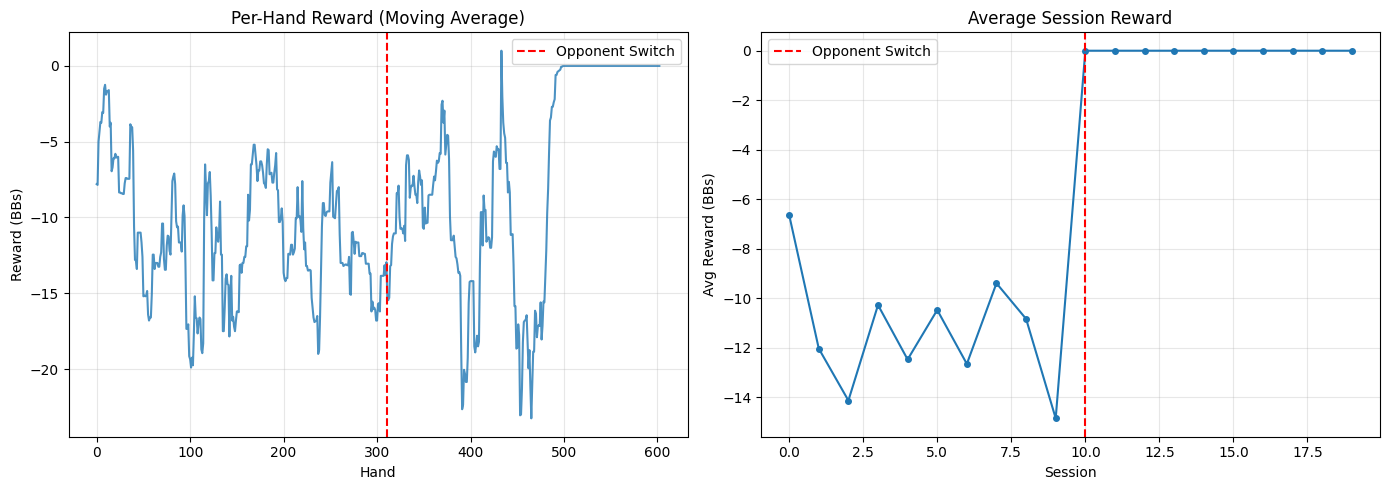

In [9]:
# Cell 9: Visualization

def moving_average(data, window=10):
    return np.convolve(data, np.ones(window)/window, mode='valid')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Per-hand rewards
if len(rewards_history) > 10:
    ma_rewards = moving_average(rewards_history, window=20)
    axes[0].plot(ma_rewards, alpha=0.8)
else:
    axes[0].plot(rewards_history)
axes[0].axvline(x=len(rewards_history)//2, color='r', linestyle='--', label='Opponent Switch')
axes[0].set_title('Per-Hand Reward (Moving Average)')
axes[0].set_xlabel('Hand')
axes[0].set_ylabel('Reward (BBs)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Per-session rewards
axes[1].plot(session_rewards, 'o-', markersize=4)
axes[1].axvline(x=len(session_rewards)//2, color='r', linestyle='--', label='Opponent Switch')
axes[1].set_title('Average Session Reward')
axes[1].set_xlabel('Session')
axes[1].set_ylabel('Avg Reward (BBs)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Cell 10: Evaluation Function

def evaluate_agent(agent: DRQNAgentWrapper, num_hands: int = 100, 
                   opponent_type: str = 'random') -> Dict:
    """
    Evaluate agent against a specific opponent type.
    
    Returns win rate, total profit, and other statistics.
    """
    env = PokerKitGymEnv(num_players=2)
    
    opponents = {
        'maniac': ManiacAgent(),
        'nit': NitAgent(),
        'random': RandomAgent()
    }
    opponent = opponents[opponent_type]
    
    # Reset for evaluation session
    agent.start_new_session()
    env.reset_session()
    
    wins = 0
    losses = 0
    ties = 0
    total_reward = 0.0
    
    for hand in range(num_hands):
        obs, info = env.reset()
        done = False
        hand_reward = 0.0
        
        while not done:
            current_player = env.get_current_player()
            legal_actions = info['legal_actions']
            
            if current_player is None:
                break
            
            if current_player == env.agent_player_index:
                action = agent.select_action(obs, legal_actions, eval_mode=True)
            else:
                action = opponent.select_action(legal_actions)
            
            obs, reward, done, truncated, info = env.step(action)
            
            if current_player == env.agent_player_index:
                hand_reward = reward
        
        total_reward += hand_reward
        if hand_reward > 0:
            wins += 1
        elif hand_reward < 0:
            losses += 1
        else:
            ties += 1
    
    results = {
        'opponent': opponent_type,
        'hands_played': num_hands,
        'wins': wins,
        'losses': losses,
        'ties': ties,
        'win_rate': wins / num_hands,
        'total_reward': total_reward,
        'avg_reward': total_reward / num_hands
    }
    
    print(f"\n=== Evaluation vs {opponent_type.upper()} ===")
    print(f"Hands: {num_hands}")
    print(f"W/L/T: {wins}/{losses}/{ties}")
    print(f"Win Rate: {results['win_rate']:.1%}")
    print(f"Total Profit: {total_reward:.1f} BBs")
    print(f"Avg Profit/Hand: {results['avg_reward']:.2f} BBs")
    
    return results

# Evaluate against each opponent type
print("\nEvaluating trained agent...")
for opp in ['random', 'maniac', 'nit']:
    evaluate_agent(agent, num_hands=100, opponent_type=opp)


Evaluating trained agent...
[Session Reset] LSTM hidden state cleared.

=== Evaluation vs RANDOM ===
Hands: 100
W/L/T: 9/13/78
Win Rate: 9.0%
Total Profit: 64.0 BBs
Avg Profit/Hand: 0.64 BBs
[Session Reset] LSTM hidden state cleared.

=== Evaluation vs MANIAC ===
Hands: 100
W/L/T: 43/39/18
Win Rate: 43.0%
Total Profit: 490.0 BBs
Avg Profit/Hand: 4.90 BBs
[Session Reset] LSTM hidden state cleared.

=== Evaluation vs NIT ===
Hands: 100
W/L/T: 0/0/100
Win Rate: 0.0%
Total Profit: 0.0 BBs
Avg Profit/Hand: 0.00 BBs


In [11]:
# Cell 11: Interactive Play Function

def play_vs_human(agent: DRQNAgentWrapper):
    """
    Interactive mode: Play against the trained agent.
    
    Human inputs actions via notebook input().
    """
    env = PokerKitGymEnv(num_players=2)
    env.agent_player_index = 0  # Bot is player 0
    human_index = 1
    
    agent.start_new_session()
    env.reset_session()
    
    action_names = ['Fold', 'Check/Call', 'Bet/Raise']
    
    print("\n" + "="*50)
    print("     HEADS-UP NO-LIMIT TEXAS HOLD'EM")
    print("             vs DRQN Bot")
    print("="*50)
    
    total_hands = 0
    human_profit = 0.0
    
    while True:
        total_hands += 1
        print(f"\n--- Hand #{total_hands} ---")
        
        obs, info = env.reset()
        done = False
        
        # Display human's hole cards
        hole_cards = env._flatten_cards(env.state.hole_cards[human_index])
        print(f"Your hole cards: {[str(c) for c in hole_cards]}")
        
        while not done:
            current_player = env.get_current_player()
            legal_actions = info['legal_actions']
            
            if current_player is None:
                break
            
            # Display board
            board = env._flatten_cards(env.state.board_cards)
            if board:
                print(f"Board: {[str(c) for c in board]}")
            
            # Display stacks
            print(f"Stacks - You: {env.state.stacks[human_index]}, Bot: {env.state.stacks[0]}")
            print(f"Pot: {sum(env.state.bets)}")
            
            if current_player == env.agent_player_index:
                # Bot's turn
                print("\n[Bot is thinking...]")
                action = agent.select_action(obs, legal_actions, eval_mode=True)
                print(f"Bot: {action_names[action]}")
            else:
                # Human's turn
                print("\nYour turn!")
                legal_str = ', '.join([f"{a}: {action_names[a]}" for a in legal_actions])
                print(f"Legal actions: [{legal_str}]")
                
                while True:
                    try:
                        action = int(input("Enter action number: "))
                        if action in legal_actions:
                            break
                        print(f"Invalid! Choose from {legal_actions}")
                    except ValueError:
                        print("Please enter a number.")
                    except KeyboardInterrupt:
                        print("\nGame ended.")
                        return
            
            obs, reward, done, truncated, info = env.step(action)
        
        # Hand complete
        human_result = env.state.stacks[human_index] - env.starting_stack
        human_profit += human_result
        
        print("\n--- Hand Complete ---")
        print(f"Final stacks - You: {env.state.stacks[human_index]}, Bot: {env.state.stacks[0]}")
        
        if human_result > 0:
            print(f"You won {human_result} chips! 🎉")
        elif human_result < 0:
            print(f"You lost {-human_result} chips. 🤖")
        else:
            print("Push! 🤝")
        
        print(f"\nSession profit: {human_profit:+.0f} chips")
        
        try:
            again = input("\nPlay another hand? (y/n): ").strip().lower()
            if again != 'y':
                break
        except KeyboardInterrupt:
            break
    
    print(f"\n=== SESSION SUMMARY ===")
    print(f"Hands played: {total_hands}")
    print(f"Total profit: {human_profit:+.0f} chips")
    print("Thanks for playing!")

# Uncomment to play:
# play_vs_human(agent)

## Summary

This notebook demonstrates a DRQN agent for No-Limit Texas Hold'em with:

1. **PokerKit Integration**: Custom Gym wrapper for fine-grained game control
2. **Dual-Input Architecture**: MLP + LSTM for state + history processing
3. **Session-Based Memory**: LSTM hidden state persists across hands to model opponents
4. **Opponent Adaptation**: Agent learns to exploit different playing styles

### Key Insight: Session vs Episode

The critical distinction is that the LSTM hidden state is **NOT** reset between hands (episodes). It only resets when starting a new session (new opponent). This allows the agent to:

- Build a model of the opponent over multiple hands
- Detect patterns like "always raises" or "folds to aggression"
- Adapt its strategy accordingly